# Ch8. 운영 위험 모델림

- 운영 위험: 부적절 or 실패한 구간 프로세스, 인력, 시스템 or 외부 이벤트로 인한 직간접적인 손실 위험
- 직접비용 ex: 법적 책임 / 절도 or 자산 감소(상각) / 세금, 라이선스, 벌금 등 / 업무 중단
- 간접비용: 기관의 결정이 미래의 불확실한 시기에 손실을 초래하는 일련의 사건을 유발할 수 있다는 점에서 기회 비용과 관련 있음
- generally, 금융기관: 운용 위험에 따른 손실 충당 위해 일정 금액의 자금을 할당함 -> 미예상 손실
- but 적절 할당 어렵; too much: 유휴 상태 ~ 기회 비용 발생 / too little: 유동성 문제
- in this chapter, 사기 or 사기 가능성이 있는 작업을 감지하는 ML 기반 모델 소개 w/ 신용카드 거래 사기 탐지 데이터셋
$\\ \rarr$ 사기 가능성 감지 & 은행이 실사 통해 상황을 조사할 수 있도록 은행에 알림: 은행이 막대한 손실을 입지 않도록 보호함

In [1]:
!pip install kagglehub

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

In [3]:
fraud_data=pd.read_csv('fraudTrain.csv')
del fraud_data['Unnamed: 0']

In [4]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

is_fraud
0    1289169
1       7506
Name: count, dtype: int64


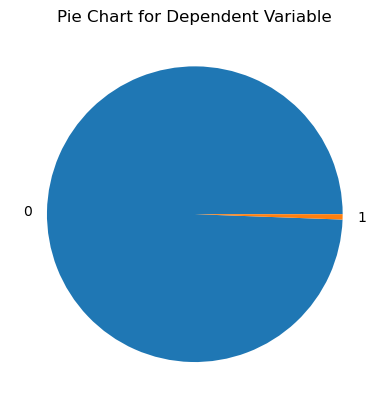

In [5]:
plt.pie(fraud_data['is_fraud'].value_counts(), labels=[0,1]) # 거래의 사기성 여부
plt.title('Pie Chart for Dependent Variable')
print(fraud_data['is_fraud'].value_counts())
plt.show() # 불균형적 관찰 수 ~ "데이터의 불균형"

In [6]:
!pip install missingno

<Axes: >

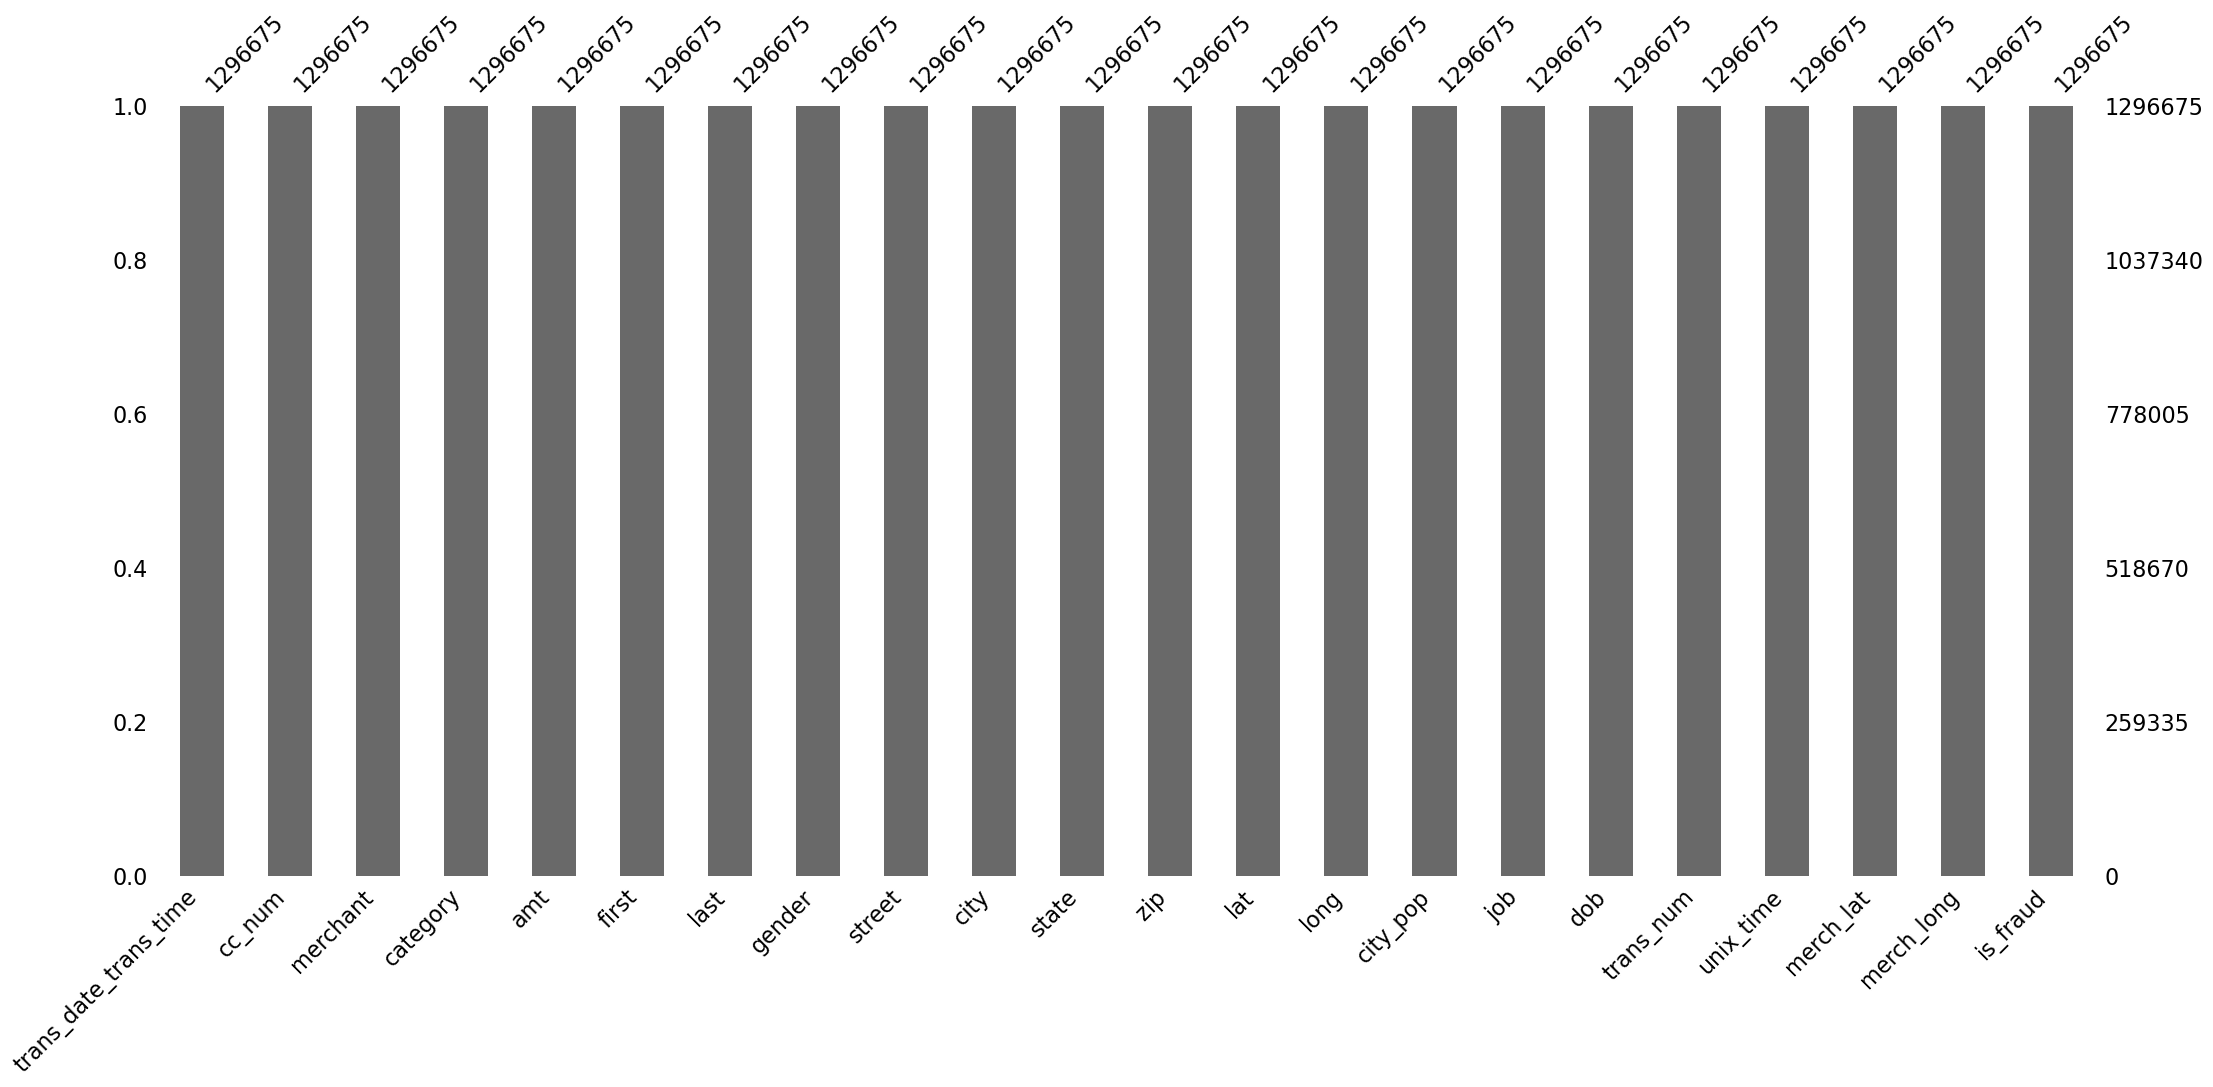

In [7]:
# 누락된 값에 대한 시각화 모듈
import missingno as msno
msno.bar(fraud_data) # 상단에 변수당 비결측 관측값의 수 나타냄, 왼쪽에는 비결측값의 백분율 ~ 결측값 없음

In [8]:
# 특정 기간 동안 사기 행위가 급증한다고 가정해 시간을 날짜 & 시간으로 나눔
fraud_data['time']=pd.to_datetime(fraud_data['trans_date_trans_time'])
del fraud_data['trans_date_trans_time']

fraud_data['days']=fraud_data['time'].dt.day_name()
fraud_data['hour']=fraud_data['time'].dt.hour

In [9]:
def fraud_cat(cols):
    k=1
    plt.figure(figsize=(20,40))
    for i in cols:
        categ=fraud_data.loc[fraud_data['is_fraud']==1, i].value_counts().sort_values(ascending=False).reset_index().head(10)
        plt.subplot(int(len(cols)/2), int(len(cols)/2), k)
        bar_plot=plt.bar(categ.iloc[:,0],categ[i])
        plt.title(f'Cases per {i} Categories')
        plt.xticks(rotation=45)
        k+=1
    return categ, bar_plot

<BarContainer object of 10 artists>

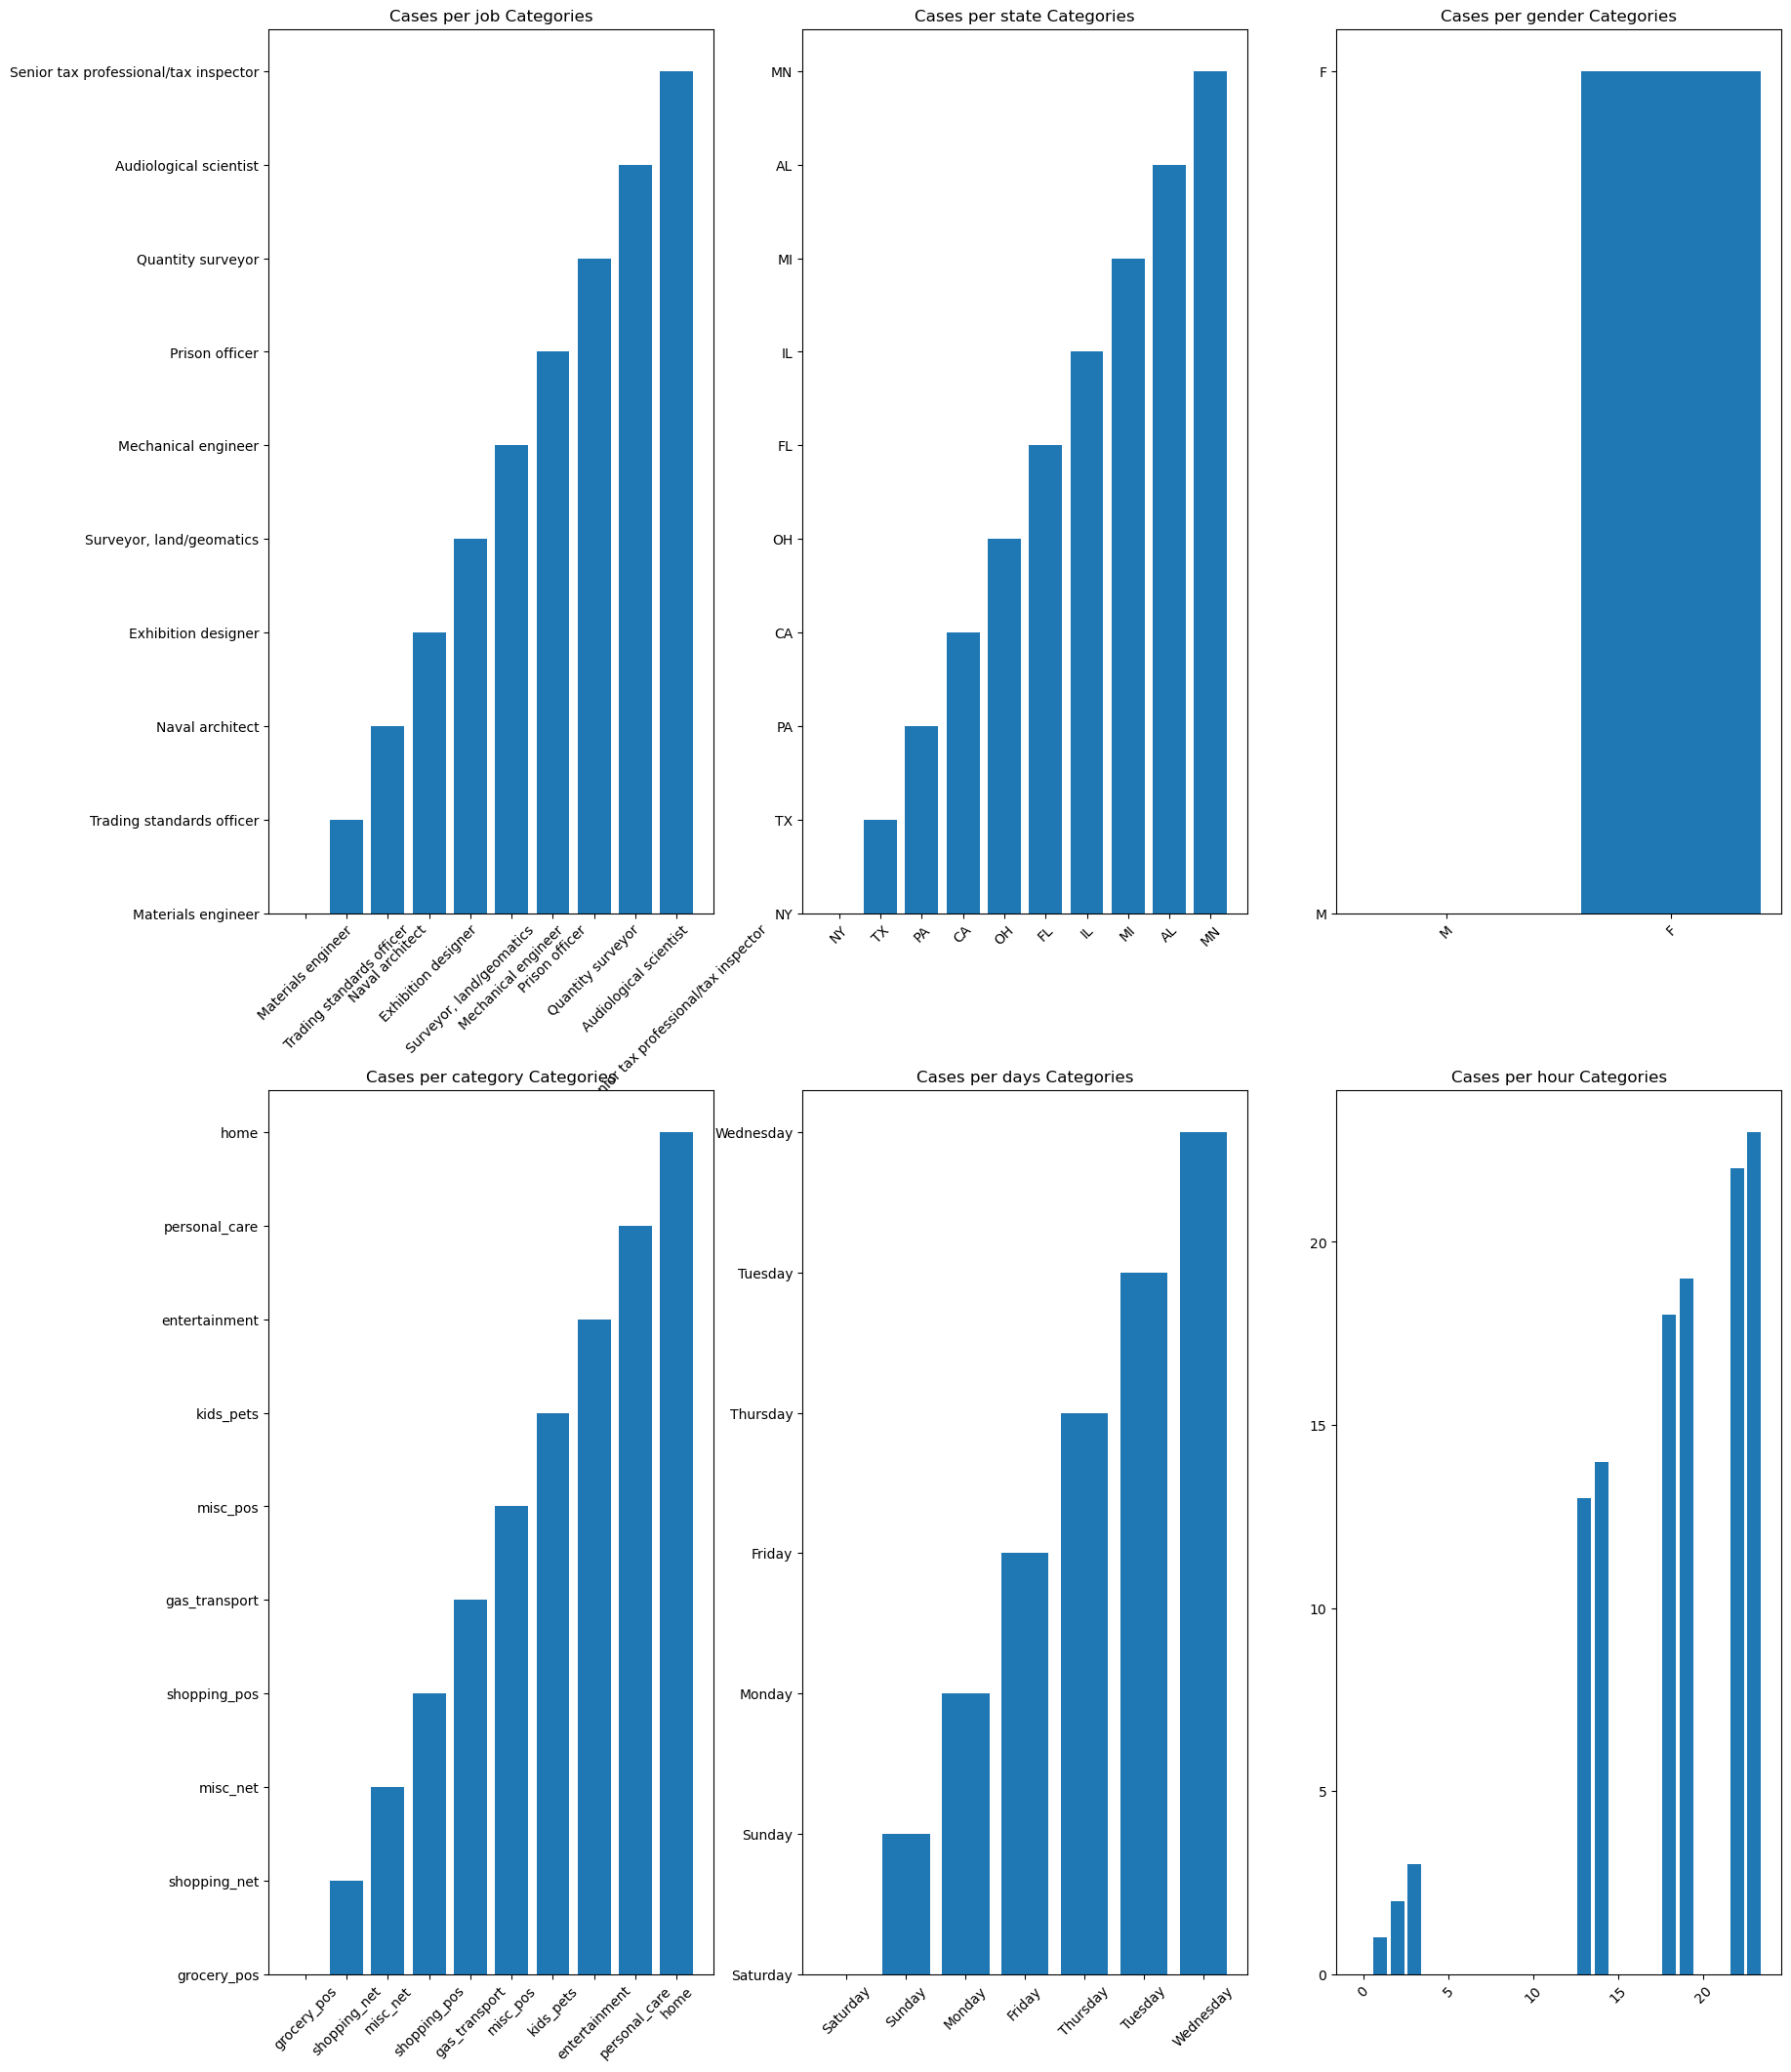

In [10]:
cols=['job','state','gender','category','days','hour']
_, bar_plot=fraud_cat(cols)
bar_plot

In [11]:
cols=['amt','gender','state','category','city_pop','job','is_fraud','days','hour']
fraud_data_df=fraud_data[cols]

In [12]:
cat_cols=fraud_data_df.select_dtypes(include='object').columns

def one_hot_encoded_cat(data, cat_cols):
    for i in cat_cols:
        df1=pd.get_dummies(data[str(i)], prefix=i, drop_first=True)
        data.drop(str(i), axis=1, inplace=True)
        data=pd.concat([data, df1], axis=1)
    return data

In [13]:
fraud_df=one_hot_encoded_cat(fraud_data_df, cat_cols)

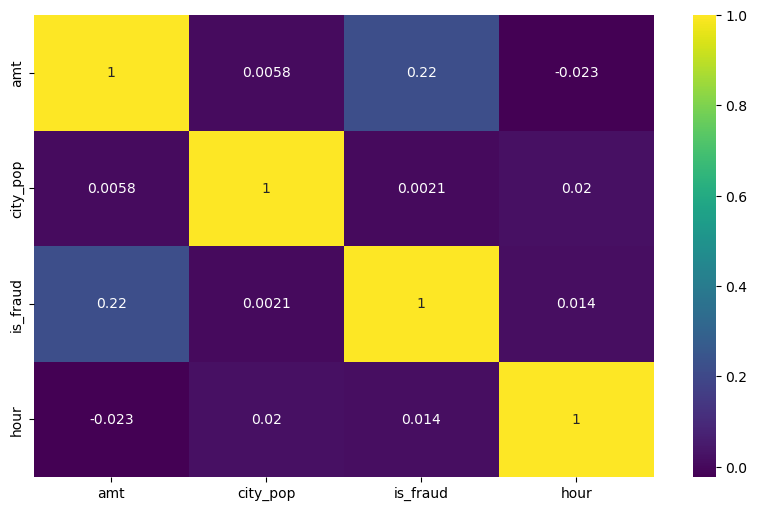

In [14]:
# 변수들 간의 상호작용 ~ 상관관계
num_col=fraud_data_df.select_dtypes(exclude='object').columns
fraud_data_df=fraud_data_df[num_col]
#del fraud_data_df['is_fraud']

plt.figure(figsize=(10,6))
corrmat=fraud_data_df.corr()
top_corr_features=corrmat.index
heat_map=sns.heatmap(corrmat, annot=True, cmap='viridis')

(\*) 사기 조사를 위한 지도 학습
- 모델 수행 전 균형 잡힌 데이터 갖는 것이 중요함
- 언더샘플링 실시: 다수 부류를 소수 부류에 일치시킴
- 소수 부류와 동일한 수의 관측값을 얻을 때까지 다수 부류의 관측값 수를 제거함

In [15]:
from sklearn.model_selection import train_test_split # 임의로 train과 test split 실시
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, f1_score)

In [16]:
non_fraud_class=fraud_df[fraud_df['is_fraud']==0]
fraud_class=fraud_df[fraud_df['is_fraud']==1]

non_fraud_count, fraud_count=len(non_fraud_class), len(fraud_class)
print('The number of observations in non_fraud_class:', non_fraud_count)
print('The number of observations in fraud_class:', fraud_count)

The number of observations in non_fraud_class: 1289169
The number of observations in fraud_class: 7506


In [17]:
non_fraud_under=non_fraud_class.sample(fraud_count) # 샘플링
under_sampled=pd.concat([non_fraud_under, fraud_class],axis=0)
X_under=under_sampled.drop('is_fraud',axis=1)
y_under=under_sampled['is_fraud']

In [18]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, random_state=0)

In [19]:
# 로지스틱 회귀
param_log={'C':np.logspace(-4,4,4), 'penalty':['l1','l2']}
log_grid=GridSearchCV(LogisticRegression(), param_grid=param_log, n_jobs=1)
log_grid.fit(X_train_under, y_train_under)
prediciton_log=log_grid.predict(X_test_under)

conf_mat_log=confusion_matrix(y_true=y_test_under, y_pred=prediciton_log)
print('confusion matrix:\n', conf_mat_log) # 참/거짓 양/음성 개수 확인
print('--'*25)
print('Classification report:\n', classification_report(y_test_under, prediciton_log))

confusion matrix:
 [[1474  370]
 [ 485 1424]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.78      1844
           1       0.79      0.75      0.77      1909

    accuracy                           0.77      3753
   macro avg       0.77      0.77      0.77      3753
weighted avg       0.77      0.77      0.77      3753



In [20]:
# 의사결정 트리
from sklearn.tree import DecisionTreeClassifier

param_dt={'max_depth': [3,5,10], 'min_samples_split':[2,4,6], 'criterion':['gini','entropy']}
dt_grid=GridSearchCV(DecisionTreeClassifier(), param_grid=param_dt, n_jobs=-1)
dt_grid.fit(X_train_under, y_train_under)
prediction_dt=dt_grid.predict(X_test_under)

conf_mat_dt=confusion_matrix(y_true=y_test_under, y_pred=prediction_dt)
print('Confusion matrix:\n', conf_mat_dt)
print('--'*25)
print('Classification report:\n', classification_report(y_test_under, prediction_dt))

Confusion matrix:
 [[1801   43]
 [  75 1834]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1844
           1       0.98      0.96      0.97      1909

    accuracy                           0.97      3753
   macro avg       0.97      0.97      0.97      3753
weighted avg       0.97      0.97      0.97      3753



In [21]:
from sklearn.ensemble import RandomForestClassifier

param_rf={'n_estimators':[20,50,100], 'max_depth':[3,5,10], 'min_samples_split':[2,4,6], 'max_features':['auto','sqrt','log2']}
rf_grid=GridSearchCV(RandomForestClassifier(), param_grid=param_rf, n_jobs=-1)
rf_grid.fit(X_train_under, y_train_under)
prediction_rf=rf_grid.predict(X_test_under)

conf_mat_rf=confusion_matrix(y_true=y_test_under, y_pred=prediction_rf)
print('Confusion matrix:\n', conf_mat_rf)
print('--'*25)
print('Classification report:\n',classification_report(y_test_under, prediction_rf))

Confusion matrix:
 [[1782   62]
 [ 423 1486]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88      1844
           1       0.96      0.78      0.86      1909

    accuracy                           0.87      3753
   macro avg       0.88      0.87      0.87      3753
weighted avg       0.89      0.87      0.87      3753



In [22]:
from xgboost import XGBClassifier
param_boost={'learning_rate':[0.01,0.1], 'max_depth':[3,5,7], 'subsample':[0.5,0.7], 'colsample_bytree':[0.5,0.7], 'n_estimators':[10,20,30]}
boost_grid=RandomizedSearchCV(XGBClassifier(), param_boost, n_jobs=-1)
boost_grid.fit(X_train_under, y_train_under)
prediction_boost=boost_grid.predict(X_test_under)

conf_mat_boost=confusion_matrix(y_true=y_test_under, y_pred=prediction_boost)
print('Confusion matrix:\n', conf_mat_boost)
print('--'*25)
print('Classification report:\n', classification_report(y_test_under, prediction_boost))

Confusion matrix:
 [[1795   49]
 [  75 1834]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1844
           1       0.97      0.96      0.97      1909

    accuracy                           0.97      3753
   macro avg       0.97      0.97      0.97      3753
weighted avg       0.97      0.97      0.97      3753



(\*) 비용 기반 사기 조사
- 언더 샘플링: 중요한 관측치를 버려야 함
- 성과 척도: 서로 다른 오분류가 미치는 다양한 경제적 영향 고려 못함 -> 기법에 따라 서로 다른 오분류 비용 발생: '비용-민감' 분류기
- 거짓양성: 분류 비용 = 잠재적 이익 손실 ~ 관리 및 기회 비용과 관련됨
- 거짓음성(사기 감지 못함): 다양한 내부 약점 & 잘못 설계된 운영 절차 암시
$\\ \rarr$ 서로 다른 오분류에 대해 다양한 비용 할당해야 함
$\\$Let 비용-민감 행렬: 참양성=거짓양성=2 / 거짓음성=거래 금액 / 참음성=0
$\\ \text{비용}=\sum^N_{i=1}y_i(c_iC_{TP_i}+(1-c_i)C_{FN_i})+(1-y_i)c_iC_{FP_i}
- $c_i$: 예측된 레이블
- $y_i$: 실제 레이블
- $N$: 관찰 수
- $C_{TP_i}$: 관리 비용 ~ 2
- $C_{FN_i}$: 거래 금액

In [24]:
fraud_df_sampled=fraud_df.sample(int(len(fraud_df)*0.2)) # 샘플링
cost_fp=2
cost_fn=fraud_df_sampled['amt'] # 사기 감지 못함
cost_tp=2
cost_tn=0
cost_mat=np.array([cost_fp*np.ones(fraud_df_sampled.shape[0]), \
                   cost_fn, cost_tp*np.ones(fraud_df_sampled.shape[0]), cost_tn*np.ones(fraud_df_sampled.shape[0])]).T # 비용 매트릭스

In [25]:
cost_log=conf_mat_log[0][1]*cost_fp+conf_mat_log[1][0]*cost_fn.mean()+conf_mat_log[1][1]*cost_tp
cost_dt=conf_mat_dt[0][1]*cost_fp+conf_mat_dt[1][0]*cost_fn.mean()+conf_mat_dt[1][1]*cost_tp
cost_rf=conf_mat_rf[0][1]*cost_fp+conf_mat_rf[1][0]*cost_fn.mean()+conf_mat_rf[1][1]*cost_tp
cost_boost=conf_mat_boost[0][1]*cost_fp+conf_mat_boost[1][0]*cost_fn.mean()+conf_mat_boost[1][1]*cost_tp

In [26]:
print(f'logistic {cost_log}, decision tree {cost_dt}, random forest {cost_rf}, xgb {cost_boost}')

logistic 37805.58213122024, decision tree 9045.378680085603, random forest 32939.375755682806, xgb 9057.378680085603


(\*) 절약 점수
- 비용 개선에 사용할 수 있는 척도
- 가장 멍청한 방법보다 우리 모델이 돈을 얼마나 아꼈는지
$\text{비용(f(S))}=\sum^N_{i=1}(y_i(c_iC_{TP_i}+(1-c_i)C_{FN_i})+(1-y_i)(c_iC_{FP_i}+(1-c_i)C_{TN_i}))$: 모델의 총 비용
- $c_i$: 훈련 집합의 각 관측치 i에 대한 예측된 레이블
- $y_i$: 부류 레이블 1 or 0 값
$\\ \text{절약(f(S))}=\frac{Cost(f(S))-Cost_l(S)}{Cost_l(S)}$
- 분자: 모델 덕분에 아낀 돈
- 분모: 아무것도 안했을 때
- 예상 손실액의 몇 %를 방어(절약)했는지
- $Cost_l=min\ Cost(f_0(S)), Cost(f_1(S))$: 아무런 사기 탐지 시스템을 도입하지 않을 때 우리가 잃어버릴 돈
- $f_0$: 부류 0, $c_0$ 예측
- $f_1$: 부류 1, $c_1$ 예측

In [27]:
!pip install costcla

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ----------------------- ---------------- 2.4/4.0 MB 16.5 MB/s eta 0:00:01
   ------------------------------- -------- 3.1/4.0 MB 10.8 MB/s eta 0:00:01
   ---------------------------------------- 4.0/4.0 MB 7.5 MB/s  0:00:00
  Created wheel for pyea: filename=pyea-0.2-py3-none-any.whl size=6061 sha256=d004b3c329968c50d1e4a3e848671917d7c58b264f5d819ea189f58b7c7509c9
  Stored in directory: c:\users\82103\appdata\local\pip\cache\wheels\8d\84\69\c2274a47ccb3c95d9102d0fbf994c7ff30ab4adf7b268d4e51
Successfully built pyea

   ---------------------------------------- 2/2 [costcla]



In [ ]:
'''
import joblib
import sys

sys.modules['sklearn.externals.joblib']=joblib

from costcla.metrics import cost_loss, savings_score
from costcla.models import BayesMinimumRiskClassifier
'''

In [ ]:
'''
버전 issue
X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test=
train_test_split(fraud_df_sampled.drop('is_fraud', axis=1), fraud_df_sampled.is_fraudm cost_mat, test_size=0.2, random_state=0)

saving_models=[]
saving_models.append(('Log. Reg.', LogisticRegression()))
saving_models.append(('Dec. Tree', DecisionTreeClassifier()))
saving_models.append(('Random Forest', RandomForestClassifier()))

saving_score_base_all=[]

for name, save_model in saving_models:
    sv_model=save_model
    sv_model.fit(X_train, y_train)
    y_pred=sv_model.predict(X_test)
    saving_score_base=savings_score(y_test, y_pred, cost_mat_test) # 절약 점수 계산
    saving_score_base_all.append(saving_score_base)
    print('The saving score for {} is {.4f}'.format(name, saving_score_base))
    print('--'*20)
'''

In [ ]:
'''
f1_score_base_all=[]

for name, save_model in saving_models:
    sv_model=save_model
    sv_model.fit(X_train, y_train)
    y_pred=sv_model.predic(X_test)
    f1_score_base=f1_score(y_test, y_pred, cost_mat_test)
    f1_score_base_all.append(f1_score_base)
    print('The F1 score for {} is {.4f}'.format(name, f1_score_base))
    print('--'*20)
'''

(\*) 비용에 민감한 모델링
- 다양한 오분류 비용을 고려해 사기를 모델링하면 어떻게 되는지 -> 절약 점수에 어떤 영향?
- traditional: 올바르게 분류, 잘못 분류 모든 예가 동일 비용 부담 가정
- costcla:  비용 민감 모델

In [ ]:
'''
from costcla.models import CostSensitiveLogisticRegression
from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.models import CostSensitiveRandomForestClassifier
'''

In [ ]:
'''
cost_sen_models=[]
cost_sen_models.append(('Log. Reg. CS', CostSensitiveLogisticRegression()))
cost_sen_models.append(('Dec. Tree CS', CostSensitiveDecisionTreeClassifier()))
cost_sen_models.append(('Random Forest CS', CostSensitiveRandomForestClassifier))

saving_cost_all=[]

for name, cost_model in cost_sen_models:
    cs_model=cost_model
    cs_model.fit(np.array(X_train), np.array(y_train), cost_mat_train)
    y_pred=cs_model.predict(np.array(X_test))
    saving_score_cost=savings_score(np.array(y_test), np.array(y_pred), cost_mat_test)
    saving_cost_all.append(saving_score_cost)
    print('The saving score for {} is {.4f}'.format(name, saving_score_cost))
    print('--'*20)
'''

(\*) 베이즈 최소 위험
- 거래가 사기로 예측되는 경우 전체 위험: 
$\\ R(c_f|S)=L(c_f|y_f)P(c_f|S)+L(c_f|y_l)P(c_l|S)$
- 거래가 합법적인 것으로 예측되는 경우 전체 위험:
$\\ R(c_l|S)=L(c_l|y_l)P(c_l|S)+L(c_l|y_f)P(c_f|S)$
- L: 비용
- f: 사기, l: 적법
- P(|): 실제 정답이 f or l일 확률과 같음
- 베이즈 최소 위험 공식:
$\\ R(c_f|S)=C_{admin}P(c_f|S) + C_{admin}P(c_l|S)$
$\\ R(c_l|S)=0 + C_{amt}P(c_f|S)$
$\\ R(c_f|s)\le R(c_l|s)$ 일 때, 적법으로 예측

In [ ]:
'''
saving_score_bmr_all=[]
for name, bmr_model in saving_models:
    f=bmr_model.fit(X_train, y_train)
    y_prob_test=f.predict_proba(np.array(X_test)): P(c_f/l|S) 구함
    f_bmr=BayesMinimumRiskClassifier() # 베이즈 최소 위험 분류자
    f_bmr.fit(np.array(y_test), y_prob_test)
    y_pred_test=f_bmr.predict(np.array(y_prob_test), cost_mat_test)
    saving_score_bmr=savings_score(y_test, y_pred_test, cost_mat_test)
    saving_score_bmr_all.append(saving_score_bmr)
    print('The saving score for {} is {:.4f}'.format(name, saving_score_bmr))
    print('--'*20)
'''

In [ ]:
'''
f1_score_bmr_all=[]

for name, bmr_model in saving_models:
    f=bmr_model.fit(X_train, y_train)
    y_prob_test=f.predict_proba(np.array(X_test))
    f_bmr=BayesMinimumRiskClassifier()
    f_bmr.fit(np.array(y_test), y_prob_test)
    y_pred_test=f_bmr.predict(np.array(y_prob_test), cost_mat_test)
    f1_score_bmr=f1_score(y_test, y_pred_test)
    f1_score_bmr_all.append(f1_score_bmr)
    print('The F1 score for {} is {:.4f}'.format(name, f1_score_bmr))
    print('--'*20)
'''

(\*) 사기 조사를 위한 비지도 학습 모델링
- 불균형 데이터 문제 해결 위해 샘플링 절차 적용할 필요 없음
- 데이터에 대한 사전 지식 필요 x
1. 자기 구성맵(Self-Organizing Map)
- 고차원 공간에서 저차원 공간을 얻는 비지도 방법
- 출력 뉴런이 활정화되기 위해 경쟁함 ~ 경쟁 학습에 의존
- 활성화된 뉴런: 위닝 뉴런
- 각 뉴런은 인접한 가중치 가짐 -> 입력 공간의 고유한 통계적 특징: 출력 공간에서 노드의 공간적 위치
- 변수 분포에 대한 가정이 없음
- 변수 간의 종속 구조
- 비선형 구조 처리
- 잡음 및 누락된 데이터 처리
$\\$(i) 승리한 노드 or 활성화된 뉴런식별 ~ 승리한 노드는 거리 척도로 식별
$\\ ||(x_t-w_i(t))||=\sqrt{\sum_j=1^n(x_{tj}-w_{tji})^2},\ i=1,2,..,n$
- x: 샘플 / w: 가중치 / k(t): 승리노드
$\\ k(t)=arg\ min||x(t)-w_i(t)||$
- 가중치 갱신:
$\\ w_i(t+1)=w_i(t)+\lambda[x(t)-w_i(t)]$
- $w_i(t)$: t번째 반복에서 승리한 뉴런 i의 가중치
- $\lambda$: 학습률
- 가중치의 적응 비율: 승리 노드에서 멀어질수록 감소함 ~ 이웃함수 $h_{ki}(t)$에 의해 정의됨
$\\ h_{ki}(t)=exp(-\frac{d^2_{ki}}{2\sigma^2(t)})$ ~ $d^2_{ki}$: 승리 뉴런과 관련 뉴런 사이 거리, $\sigma^2(t)$: 반복 t에서의 반경
- 가중치 갱신:
$\\ w_i(t+1)=w_i(t)+\lambda h_{ki}(t)[x_t-w_i(t)]

In [33]:
# 사기 데이터에 두 가지 부류 -> 2x1 차원 구조 가져야 함
from sklearn.preprocessing import StandardScaler
standard=StandardScaler()
scaled_fraud=standard.fit_transform(X_under)

In [34]:
!pip install sklearn_som

In [ ]:
from sklearn_som.som import SOM
som=SOM(m=2, n=1, dim=scaled_fraud.shape[1]) # 뉴런이 2개(2개로 군집화)
som.fit(scaled_fraud)
predictions_som=som.predict(np.array(scaled_fraud)) # 각 데이터에 군집 할당

predictions_som=np.where(predictions_som==1, 0, 1) # 1이면 0으로, 0이면 1로 뒤집

print('Classification report:\n', classification_report(y_under, predictions_som))

Classification report:
               precision    recall  f1-score   support

           0       0.49      0.39      0.43      7506
           1       0.49      0.60      0.54      7506

    accuracy                           0.49     15012
   macro avg       0.49      0.49      0.49     15012
weighted avg       0.49      0.49      0.49     15012



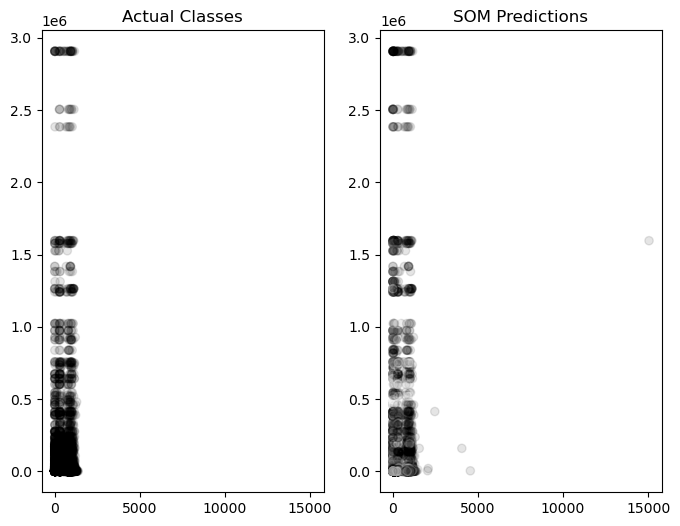

In [36]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(8,6))
x=X_under.iloc[:,0]
y=X_under.iloc[:,1]

ax[0].scatter(x, y, alpha=0.1, cmap='Greys', c=y_under)
ax[0].title.set_text('Actual Classes')
ax[1].scatter(x, y, alpha=0.1, cmap='Greys', c=predictions_som)
ax[1].title.set_text('SOM Predictions')

2. 오토인코더
- 은닉층을 통해 입력을 출력으로 변환하도록 훈련된 비지도 딥러닝 모델
- 인코더와 디코더 두 부분으로 구성된다는 점에서 다른 구조와 구분됨
- 인코더: 특징 추출 기능 ~ h=f(x) / 디코더: 재구성 기능 ~ r=g(h)
$\\$(i) 불완전 오토인코더
- 은닉층 h가 훈련 데이터 x보다 작은 차원을 가짐
- 목적: 손실함수를 최소화해 데이터의 잠재 속성을 포착함
- $L(x, g(f(x)))$ ~ 손실함수

(ii) 희소 오토인코더
- 재구성 오류에 희소성 부과 
- L1 정규화: $argmin_{g,f}L(x,g(f(x)))+\lambda(h)$ ~ h: 인코더 출력
- 쿨백-라이블러 발산: 두 확률 분포 사이의 거리 측정해 두 확률 분포의 유사성 알려줌
$\\$: $L(x,\hat{x})+\sum_jKL(\rho||\hat{\rho}||)$
- $\rho,\ \hat{\rho}$: 각각 이상적 분포, 관찰된 분포

(\*) 잡음 제거 오토인코더
- 패널티 항 $\lambda$ 대신 입력 데이터에 잡음 추가 -> 이 재구성에서 학습
- Minimize $L(x,g(f(\hat{x})))$

In [37]:
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras import regularizers

In [ ]:
#fraud_df[['amt','city_pop','hour']]=StandardScaler().fit_transform(fraud_df[['amt','city_pop','hour']])

X_train, X_test=train_test_split(fraud_df[['amt']], test_size=0.2, random_state=123)
X_train=X_train.drop(['is_fraud'],axis=1).values
y_test=X_test['is_fraud']
X_test=X_test.drop(['is_fraud'], axis=1).values

In [41]:
autoencoder=keras.Sequential()
autoencoder.add(Dense(X_train_under.shape[1], activation='tanh',activity_regularizer=regularizers.l1(10e-5), input_dim=X_train_under.shape[1]))

# Encoder
autoencoder.add(Dense(64, activation='tanh'))
autoencoder.add(Dense(32, activation='relu'))

# Encoder
autoencoder.add(Dense(32, activation='elu'))
autoencoder.add(Dense(64, activation='tanh'))
autoencoder.add(Dense(X_train_under.shape[1], activation='elu'))
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary

<bound method Model.summary of <Sequential name=sequential, built=True>>

In [ ]:
batch_size=200
epochs=100

X_train=X_train.astype('float32')
X_test=X_test.astype('float32')

history=autoencoder.fit(X_train, X_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(X_test, X_test), verbose=0).history

autoencoder_pred=autoencoder.predict(X_test)
mse=np.mean(np.power(X_test-autoencoder_pred, 2), axis=1)
error_df=pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.describe()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()